In [1]:
from C4I import benchmarks, clustering, evaluation, investment, risk_factors, utils
import pandas as pd
import numpy as np
import pickle

Source


In [3]:
def An_Unsupervised_Learning_Framework(X, n_pcs, len_fold, n_win,temp_path=None,
                                scaler_pre='MinMax', coll_threshold=0.5, SEED=1,
                                lasso_fold=5, min_rfs=2, max_rfs=4, n_round=3,
                                scaler='Standard',
                                opt_hyper_port={'maxiter':200, 'disp':True},
                                port_select=3, verbose=True):
    '''
    INPUT:
        X: DataFrame, contains assets daily prices
        n_pcs: number of Principal Components to consider
        len_fold: int, length of each fold
        n_win: int, number of windows for the pooled regression
        temp_path: None or str, path for temp savings. If None, there are no
            temp savings. Default=None
        scaler_pre: str representing the scaler to use in preprocessing, either
            'Standard' or 'MinMax'. Other values will result in no scaling.
            Default='Standard'
        coll_threshold: float, correlation threshold for collinearity filter
        SEED: int, seed to set random values
        lasso_fold: int, number of folds for the cross validation. Default = 5
        min_rfs: int, minimum number of risk factors to be saved. Default = 2
        max_rfs: int, maximum number of risk factors to be saved. Default = 4
        n_round: int, number of decimals considered (if <=0, no round).Default=3
        scaler: str representing the scaler to use, either 'Standard' or
            'MinMax'. Other values will result in no scaling. Default='Standard'
        opt_hyper_port: dcit, hyperparameters for the minimizer, containing two
            keys: 'maxiter' and 'disp'. Default={'maxiter':200, 'disp':True}
        port_select: int, number of portfolios to select. Default=3
        verbose: bool, manages the verbosity. Default=True
    OUTPUT:
        target_portfolios: list, containing weights of the optimal portfolio
    '''
    from sklearn.preprocessing import MinMaxScaler, StandardScaler
    
    #----- From prices to returns
    X.index = pd.to_datetime(X.index)
    # Monthly returns
    XM = utils.DailyPrice2MonthlyReturn(X)
    # Daily returns
    XD = utils.DailyPrice2DailyReturn(X)
    # Scale data
    if scaler_pre == 'Standard':
        XD = pd.DataFrame( StandardScaler().fit_transform(XD.values),
                          index = XD.index, columns = XD.columns )
        XM = pd.DataFrame( StandardScaler().fit_transform(XM.values),
                          index = XM.index, columns = XM.columns )
    elif scaler_pre == 'MinMax':
        XD = pd.DataFrame( MinMaxScaler().fit_transform(XD.values),
                          index = XD.index, columns = XD.columns )
        XM = pd.DataFrame( MinMaxScaler().fit_transform(XM.values),
                          index = XM.index, columns = XM.columns )
    
    #----- Create Risk Factors
    if temp_path != None:
        try:
            PCs = pd.read_csv(f'{temp_path}/RiskFactors.csv', index_col=0)
            PCs.index = pd.to_datetime(PCs.index)
        except:
            PCs = risk_factors.CreateRiskFactors([XD, XM], n_pcs,
                                                 gran_names=['Daily','Monthly'],
                                                 threshold=coll_threshold,
                                                 SEED=SEED)
            PCs.to_csv(f'{temp_path}/RiskFactors.csv')
    else:
        PCs = risk_factors.CreateRiskFactors([XD, XM], n_pcs,
                                             gran_names=['Daily', 'Monthly'],
                                             threshold=coll_threshold,SEED=SEED)
    if verbose:
        print('Risk Factors successfully extracted!\n')

    #----- Apply Features Selection
    #Check if there are previous savings
    if temp_path != None:
        try:
            with open(f'{temp_path}/Saved_RFs.pickle','rb') as f:
                saved_rf = pickle.load(f)
        except:
            saved_rf = dict()
    else:
        saved_rf = dict()
    #Go on with features selection
    Grid = {'alpha':np.logspace(-11, -2, num=25, base=np.e),
        'tau':np.linspace(0.5, 1.5, 11)}
    
    cnt = 0
    for col in XD.columns[len(saved_rf.keys()):]:
        cnt += 1
        if verbose:
            print(f'Optimizing hyperparameters for asset {col}')
            print(f'Optimizing hyperparemeters for asset num {cnt} remaining {len(XD.columns[len(saved_rf.keys()):])}')

        flag, res = clustering.A_Lasso_Grid_Search(series=XD[col],
                                                   Exog=PCs.values,
                                                   grid=Grid,
                                                   n_fold=lasso_fold,
                                                   len_fold=len_fold,
                                                   min_rfs=min_rfs,
                                                   max_rfs=max_rfs,
                                                   scaler=scaler)
        #If the result is positive, store the hyperparameters
        if flag:
            saved_rf[col] = res
            if verbose:
                print(f'Optimization result: {res}')
        #Otherwise, make a new, more accurate search
        else:
            if res == -1:
                temp_Grid = {'alpha':np.logspace(-16, -11,num=25,base=np.e),
                            'tau':np.linspace(0.5, 1.5, 11)}
            elif res == 1:
                temp_Grid = {'alpha':np.logspace(-3, 3, num=25, base=np.e),
                            'tau':np.linspace(0.5, 1.5, 11)}
            else:
                temp_Grid = {'alpha':np.logspace(-11, -2,num=40,base=np.e),
                            'tau':np.linspace(0.5, 2, 20)}
            flag, res = clustering.A_Lasso_Grid_Search(series=XD[col],
                                                       Exog=PCs.values,
                                                       grid=temp_Grid,
                                                       n_fold=lasso_fold,
                                                       len_fold=len_fold,
                                                       min_rfs=min_rfs,
                                                       max_rfs=max_rfs,
                                                       scaler=scaler)
            if flag:
                saved_rf[col] = res
                if verbose:
                    print(f'Optimization result: {res}')
        if temp_path != None:
            with open(f'{temp_path}/Saved_RFs.pickle','wb') as f:
                pickle.dump(saved_rf, f)

    #----- Create Clustering
    #Create clusters
    clusters = clustering.Clustering(saved_rf)
    if verbose:
        print('Total clusters:')
        for n_clust, cluster in enumerate(clusters):
            print(f'Cluster {n_clust}, Risk factors: {cluster[0]},\
            Cluster Dimension: {len(cluster[1])}')
            print(f'Assets in the cluster: {cluster[1]}')
    #Save useful clusters
    clusters = clustering.UsefulClusters(clusters, saved_rf)
    if verbose:
        print('\nUseful clusters:')
        for n_clust, cluster in enumerate(clusters):
            print(f'Cluster {n_clust}, Risk factors: {cluster[0]}')
            print(f'Assets in the cluster: {cluster[1]}')

    #----- Investment Strategy
    target_portfolios = investment.Create_Portfolios(XD=XD, Exog=PCs.values,
                                        clusters=clusters,
                                        target_function=utils.Expected_Sharpe,
                                        windows_number=n_win,
                                        scaler=scaler, opt_hyper=opt_hyper_port,
                                        port_to_select=port_select)
    #Adjust portfolios weight to obtain one output portfolio
    for port in target_portfolios:
        port[1] = port[1]/port_select
    return target_portfolios


Modified code

In [4]:
import matplotlib.pyplot as plt
import pandas as pd 

path = 'data'
base_line_data = 'Dataset'
X = pd.read_csv(f'{path}/close_price.csv')
X['Date'] = X['Date'].apply(lambda x: pd.to_datetime(x).date())

X.set_index('Date', inplace=True)
X.index = pd.to_datetime(X.index)
print(X.index)
print(X.head())
X.dropna(axis=1, how='any', inplace=True)
X = X.iloc[:, :100]
print(X.head())
test_start = '2022-12-21'
XD = utils.DailyPrice2DailyReturn(X)

DatetimeIndex(['2016-01-04', '2016-01-05', '2016-01-06', '2016-01-07',
               '2016-01-08', '2016-01-11', '2016-01-12', '2016-01-13',
               '2016-01-14', '2016-01-15',
               ...
               '2023-08-17', '2023-08-18', '2023-08-21', '2023-08-22',
               '2023-08-23', '2023-08-24', '2023-08-25', '2023-08-28',
               '2023-08-29', '2023-08-30'],
              dtype='datetime64[ns]', name='Date', length=1928, freq=None)
                   MMM        AOS        ABT       ABBV       ABMD        ACN  \
Date                                                                            
2016-01-04  113.048523  33.202068  37.160885  41.186237  85.239998  89.974754   
2016-01-05  113.541328  33.016586  37.152229  41.014664  85.000000  90.443031   
2016-01-06  111.254501  32.362957  36.840607  41.021812  85.300003  90.266327   
2016-01-07  108.544174  30.781895  35.957676  40.900269  81.919998  87.615585   
2016-01-08  108.174561  29.686659  35.204590  39.

In [5]:
len(XD.columns)

100

In [6]:
test_start_12fold = ['2022-09-01', 
                     '2022-10-01', 
                     '2022-11-01', 
                     '2022-12-01', 
                     '2023-01-01', 
                     '2023-02-01', 
                     '2023-03-01', 
                     '2023-04-01', 
                     '2023-05-01', 
                     '2023-06-01', 
                     '2023-07-01', 
                     '2023-08-01',
                     '2023-09-01']
                     

Training and Testing

In [7]:
portfolios = []
for i in range (12):
    print("fold: ", i)
    X_test = XD[ XD.index >= test_start_12fold[i]]
    X_test_each_fold = X_test[ X_test.index < test_start_12fold[i + 1]]
    X_each_fold = X[ X.index < test_start_12fold[i] ]
    #Obtain portfolio value in the test set
    target_portfolio = An_Unsupervised_Learning_Framework(X_each_fold, n_pcs=7,
                                                            len_fold=42, n_win=50)
    portfolios.append(target_portfolio)
                                              

fold:  0
Risk Factors successfully extracted!

Optimizing hyperparameters for asset MMM
Optimizing hyperparemeters for asset num 1 remaining 100
Optimization result: [0, 3, 4]
Optimizing hyperparameters for asset AOS
Optimizing hyperparemeters for asset num 2 remaining 99
Optimization result: [0, 4, 5]
Optimizing hyperparameters for asset ABT
Optimizing hyperparemeters for asset num 3 remaining 98
Optimization result: [0, 1]
Optimizing hyperparameters for asset ABBV
Optimizing hyperparemeters for asset num 4 remaining 97
Optimization result: [0, 3]
Optimizing hyperparameters for asset ACN
Optimizing hyperparemeters for asset num 5 remaining 96
Optimization result: [0, 1]
Optimizing hyperparameters for asset ATVI
Optimizing hyperparemeters for asset num 6 remaining 95
Optimization result: [0, 1, 4, 8]
Optimizing hyperparameters for asset ADM
Optimizing hyperparemeters for asset num 7 remaining 94
Optimization result: [0, 1, 4, 6]
Optimizing hyperparameters for asset ADBE
Optimizing hype

In [8]:
portfolios

[[[['ABBV', 'AMGN', 'BIIB', 'BMY', 'CMG'],
   array([-4.64382064e-02, -5.84911633e-02,  1.76263834e-01, -4.07835108e-06,
           5.21360510e-02])],
  [['APD',
    'LNT',
    'MO',
    'AEE',
    'AMT',
    'APH',
    'ADI',
    'AMAT',
    'ATO',
    'BKNG',
    'CZR',
    'CNP',
    'CHD'],
   array([-1.90061068e-02, -4.38775822e-02, -3.39743384e-02, -4.30590342e-04,
           1.43118265e-01, -1.12980145e-04,  6.66129654e-03, -1.31498505e-06,
          -2.24367419e-02,  8.03715047e-04, -2.32407646e-02, -2.00864025e-02,
           1.95832351e-02])],
  [['ARE', 'AWK', 'ADP', 'BDX', 'CDW'],
   array([ 0.14257417, -0.07003526, -0.08393469,  0.02911717, -0.00767204])]],
 [[['AMT', 'APH', 'ADI', 'AON', 'AMAT', 'ATO', 'CZR', 'CHD'],
   array([ 1.77305395e-01, -1.03371426e-02,  3.51932425e-04, -2.98439002e-02,
          -1.46803125e-06, -1.04914377e-01, -7.98903897e-03,  2.59007941e-03])],
  [['ARE', 'AWK', 'BDX', 'CDW'],
   array([ 0.15118836, -0.09741125,  0.01598572, -0.06874801])],
  

In [19]:
 #Evaluate results
reduce_earning = 0.9
port_test_12fold = list()
for i in range (12):
    X_test = XD[ XD.index >= test_start_12fold[i]]
    X_test_each_fold = X_test[ X_test.index < test_start_12fold[i + 1]]
    # port_test = investment.InvestmnetWithEarningFilter(X_test_each_fold, target_portfolio, earnings_by_tickers, pre_period_by_ticker, post_period_by_ticker, 
    #                                                    initial_capital=1000, reduce_earning=reduce_earning)
    port_test = investment.Investment(X_test_each_fold, target_portfolio, initial_capital=1000)
    print('\nProposed strategy for ' + str(i + 1) + ' fold')
    port_test_12fold.append(port_test)
    evaluation.Strategy_Evaluation(port_test)
    print('\n')


Proposed strategy for 1 fold
Percentage Profit: -1.083%
Profit Factor: 0.624
Percentage Drawdown: 2.024%
Recovery Factor: -0.53
Sharpe Ratio: -2.153
Sortino Ratio: -1.842



Proposed strategy for 2 fold
Percentage Profit: 1.357%
Profit Factor: 1.59
Percentage Drawdown: 0.91%
Recovery Factor: 1.478
Sharpe Ratio: 2.957
Sortino Ratio: 6.32



Proposed strategy for 3 fold
Percentage Profit: 1.392%
Profit Factor: 1.412
Percentage Drawdown: 1.415%
Recovery Factor: 0.979
Sharpe Ratio: 2.058
Sortino Ratio: 2.665



Proposed strategy for 4 fold
Percentage Profit: -0.516%
Profit Factor: 0.595
Percentage Drawdown: 0.747%
Recovery Factor: -0.691
Sharpe Ratio: -3.067
Sortino Ratio: -5.703



Proposed strategy for 5 fold
Percentage Profit: 0.273%
Profit Factor: 1.217
Percentage Drawdown: 0.918%
Recovery Factor: 0.294
Sharpe Ratio: 1.064
Sortino Ratio: 2.38



Proposed strategy for 6 fold
Percentage Profit: -1.27%
Profit Factor: 0.32
Percentage Drawdown: 1.401%
Recovery Factor: -0.905
Sharpe Ratio: 

In [21]:
with open('./results/benchmark/benchmark_100_port_test.txt', 'w') as file:
	for item in port_test_12fold:
		file.write(str(item)+"\n")
	file.close()

In [9]:
## Earnings calendars
earnings_by_tickers = {}
earnings_file_path = './data/earnings_data.txt'
with open(earnings_file_path, 'r') as file:
    for line in file:
        ticker = line.split(':')[0]
        dates = line.split(':')[1].strip().split(',')
        earnings_by_tickers[ticker] = dates
        
optimized_earnings_file_path = './data/earnings_period.txt'
pre_period_by_ticker = {}
post_period_by_ticker = {}
with open(optimized_earnings_file_path, 'r') as fr:
    for line in fr:
        parts = line.split(',')
        ticker = parts[0]
        pre = float(parts[1])
        post = float(parts[2])
        pre_period_by_ticker[ticker] = pre
        post_period_by_ticker[ticker] = post

In [15]:
 #Evaluate results
for reduce in range(1, 20):
    reduce_earning = reduce / 10
    port_test_12fold = list()
    print('reduce earning: ', reduce_earning)
    for i in range (12):
        X_test = XD[ XD.index >= test_start_12fold[i]]
        X_test_each_fold = X_test[ X_test.index < test_start_12fold[i + 1]]
        port_test = investment.InvestmnetWithEarningFilter(X_test_each_fold, target_portfolio, earnings_by_tickers, pre_period_by_ticker, post_period_by_ticker, 
                                                        initial_capital=1000, reduce_earning=reduce_earning)
        # port_test = investment.Investment(X_test_each_fold, target_portfolio, initial_capital=1000)
        print('\nProposed strategy with filter for ' + str(i + 1) + ' fold')
        port_test_12fold.append(port_test)
        evaluation.Strategy_Evaluation(port_test)
        print('\n')

    with open(f'./results/earning_filter/benchmark_with_earning_filter_{reduce_earning}_100_port_test.txt', 'w') as file:
        for item in port_test_12fold:
            file.write(str(item)+"\n")
        file.close()

reduce earning:  0.1

Proposed strategy with filter for 1 fold
Percentage Profit: -0.155%
Profit Factor: 0.908
Percentage Drawdown: 1.108%
Recovery Factor: -0.138
Sharpe Ratio: -0.631
Sortino Ratio: -1.287



Proposed strategy with filter for 2 fold
Percentage Profit: 0.786%
Profit Factor: 1.659
Percentage Drawdown: 0.832%
Recovery Factor: 0.94
Sharpe Ratio: 2.686
Sortino Ratio: 3.984



Proposed strategy with filter for 3 fold
Percentage Profit: -0.135%
Profit Factor: 0.88
Percentage Drawdown: 0.79%
Recovery Factor: -0.171
Sharpe Ratio: -0.564
Sortino Ratio: -0.503



Proposed strategy with filter for 4 fold
Percentage Profit: -0.248%
Profit Factor: 0.746
Percentage Drawdown: 0.619%
Recovery Factor: -0.399
Sharpe Ratio: -1.835
Sortino Ratio: -2.866



Proposed strategy with filter for 5 fold
Percentage Profit: 0.974%
Profit Factor: 3.921
Percentage Drawdown: 0.176%
Recovery Factor: 5.506
Sharpe Ratio: 5.028
Sortino Ratio: 17.146



Proposed strategy with filter for 6 fold
Percentage P

In [22]:
#Evaluate benchmark
min_test_12fold = list()
for i in range (12):
    X_test = XD[ XD.index >= test_start_12fold[i]]
    X_test_each_fold = X_test[ X_test.index < test_start_12fold[i + 1]]
    X_each_fold = X[ X.index < test_start_12fold[i]]
    XD_each_fold = utils.DailyPrice2DailyReturn(X_each_fold)
    min_test = benchmarks.Minimal_Variance_Portfolio(XD_each_fold, X_test_each_fold)
    print('Minimal Variance Portfolio for ' + str(i + 1) + ' fold')
    evaluation.Strategy_Evaluation(min_test)
    min_test_12fold.append(min_test)
    evaluation.Strategy_Evaluation(min_test)
    print('\n')

Optimization terminated successfully    (Exit mode 0)
            Current function value: 1.0943786390439031e-05
            Iterations: 104
            Function evaluations: 10509
            Gradient evaluations: 104
Minimal Variance Portfolio for 1 fold
Percentage Profit: 0.903%
Profit Factor: 1.916
Percentage Drawdown: 0.596%
Recovery Factor: 1.516
Sharpe Ratio: 3.259
Sortino Ratio: 6.422
Percentage Profit: 0.903%
Profit Factor: 1.916
Percentage Drawdown: 0.596%
Recovery Factor: 1.516
Sharpe Ratio: 3.259
Sortino Ratio: 6.422


Optimization terminated successfully    (Exit mode 0)
            Current function value: 1.1048893152855934e-05
            Iterations: 108
            Function evaluations: 10914
            Gradient evaluations: 108
Minimal Variance Portfolio for 2 fold
Percentage Profit: 0.841%
Profit Factor: 1.697
Percentage Drawdown: 0.78%
Recovery Factor: 1.064
Sharpe Ratio: 3.416
Sortino Ratio: 4.379
Percentage Profit: 0.841%
Profit Factor: 1.697
Percentage Drawdown: 

In [23]:
file = open('./results/benchmark/min_100_test_model_and_statistics_last.txt','w')
for item in min_test_12fold:
    file.write(str(item)+"\n")
file.close()

In [24]:
mean_var_test_12fold = list()
for i in range (12):
    print('Start New')
    X_test = XD[ XD.index >= test_start_12fold[i]]
    X_test_each_fold = X_test[ X_test.index < test_start_12fold[i + 1]]
    X_each_fold = X[ X.index < test_start_12fold[i]]
    XD_each_fold = utils.DailyPrice2DailyReturn(X_each_fold)
    print('Start optimization')
    mean_var_test = benchmarks.Mean_Variance_Portfolio(XD_each_fold, X_test_each_fold)
    print('Mean-Variance Portfolio for ' + str(i + 1) + ' fold')
    mean_var_test_12fold.append(mean_var_test)
    print('\n')

Start New
Start optimization
Optimization terminated successfully    (Exit mode 0)
            Current function value: -25.89905944510592
            Iterations: 141
            Function evaluations: 14663
            Gradient evaluations: 141
Mean-Variance Portfolio for 1 fold


Start New
Start optimization
Optimization terminated successfully    (Exit mode 0)
            Current function value: -25.12190929280529
            Iterations: 141
            Function evaluations: 14660
            Gradient evaluations: 141
Mean-Variance Portfolio for 2 fold


Start New
Start optimization
Optimization terminated successfully    (Exit mode 0)
            Current function value: -24.43127867598779
            Iterations: 146
            Function evaluations: 15168
            Gradient evaluations: 146
Mean-Variance Portfolio for 3 fold


Start New
Start optimization
Optimization terminated successfully    (Exit mode 0)
            Current function value: -24.704847956891648
            Iterat

In [25]:
file = open('./results/benchmark/mean_100_test_model_and_statistics_last.txt','w')
for item in mean_var_test_12fold:
    file.write(str(item)+"\n")
file.close()

In [26]:
proposed = pd.read_csv('./results/benchmark/benchmark_100_port_test.txt', header = None, sep = '\t')
i = 0
skip_rows = list()
for item in proposed[0]:
    if proposed[0][i] == "Name: Portfolio, dtype: float64" or proposed[0][i] == "Date":
        skip_rows.append(i)
    i = i + 1
proposed_deleted = pd.read_csv('proposed_model_and_statistics.txt', header = None, sep = '    ', skiprows = skip_rows)
proposed_deleted[0] = pd.to_datetime(proposed_deleted[0])
proposed_deleted.columns =['Date', 'Return_proposed']
proposed_deleted = proposed_deleted.set_index('Date')
proposed_12_fold_read = list()
for i in range(12):
    month = i + 9
    if month > 12:
        month = month - 12
        
    temp = proposed_deleted.loc[
         proposed_deleted.index.month == month
    ]
    series = temp.iloc[:,0]
    temp = pd.Series(series, index = temp.index) 
    proposed_12_fold_read.append(temp)

/var/folders/75/sbcy5_zx3yxgz1xj55ggdxd80000gn/T/ipykernel_6210/19282374.py:8: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  proposed_deleted = pd.read_csv('proposed_model_and_statistics.txt', header = None, sep = '    ', skiprows = skip_rows)


In [31]:
mean = pd.read_csv('mean_var_test_model_and_statistics.txt', header = None, sep = '\t')
i = 0
skip_rows = list()
for item in mean[0]:
    if mean[0][i] == "Name: Mean-Variance, dtype: float64" or mean[0][i] == "Date":
        skip_rows.append(i)
    i = i + 1
mean_deleted = pd.read_csv('mean_var_test_model_and_statistics.txt', header = None, sep = '    ', skiprows = skip_rows)
mean_deleted[0] = pd.to_datetime(mean_deleted[0])
mean_deleted.columns =['Date', 'Return_mean']
mean_deleted = mean_deleted.set_index('Date')
mean_12_fold_read = list()
for i in range(12):
    month = i + 9
    if month > 12:
        month = month - 12
        
    temp = mean_deleted.loc[
         mean_deleted.index.month == month
    ]
    series = temp.iloc[:,0]
    temp = pd.Series(series, index = temp.index) 
    mean_12_fold_read.append(temp)

/var/folders/75/sbcy5_zx3yxgz1xj55ggdxd80000gn/T/ipykernel_10603/129751125.py:8: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  mean_deleted = pd.read_csv('mean_var_test_model_and_statistics.txt', header = None, sep = '    ', skiprows = skip_rows)


In [30]:
min = pd.read_csv('./results/benchmark/min_100_test_model_and_statistics_last.txt', header = None, sep = '\t')
i = 0
skip_rows = list()
for item in min[0]:
    if min[0][i] == "Name: Minimal Variance, dtype: float64" or min[0][i] == "Date":
        skip_rows.append(i)
    i = i + 1
min_deleted = pd.read_csv('min_test_model_and_statistics.txt', header = None, sep = '    ', skiprows = skip_rows)
min_deleted[0] = pd.to_datetime(min_deleted[0])
min_deleted.columns =['Date', 'Return_min']
min_deleted = min_deleted.set_index('Date')
min_12_fold_read = list()
for i in range(12):
    month = i + 9
    if month > 12:
        month = month - 12
        
    temp = min_deleted.loc[
         min_deleted.index.month == month
    ]
    Series = temp.iloc[:,0]
    temp = pd.Series(Series, index = temp.index) 
    min_12_fold_read.append(temp)

/var/folders/75/sbcy5_zx3yxgz1xj55ggdxd80000gn/T/ipykernel_10603/405223276.py:8: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  min_deleted = pd.read_csv('min_test_model_and_statistics.txt', header = None, sep = '    ', skiprows = skip_rows)


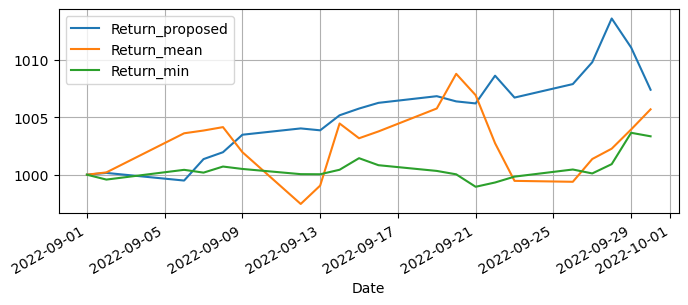

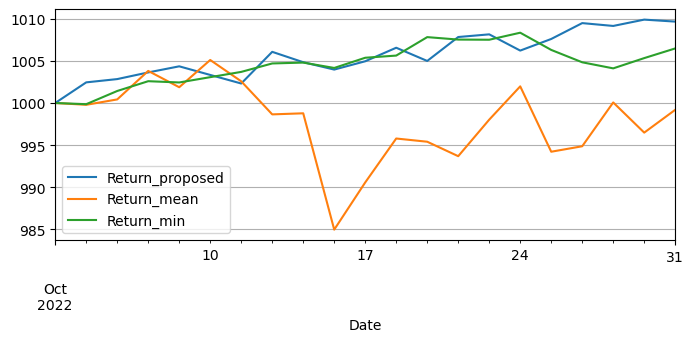

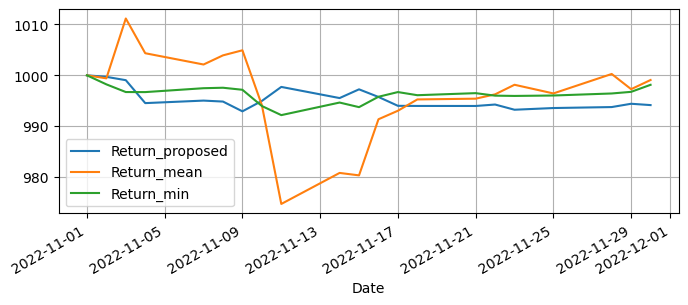

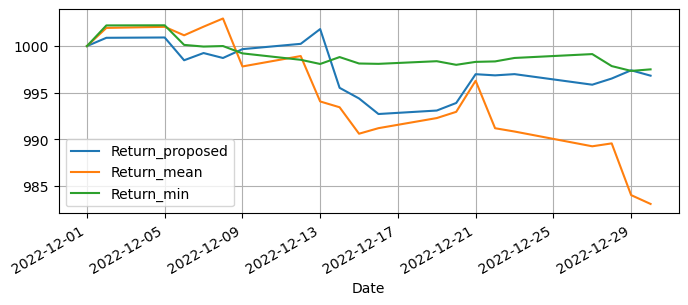

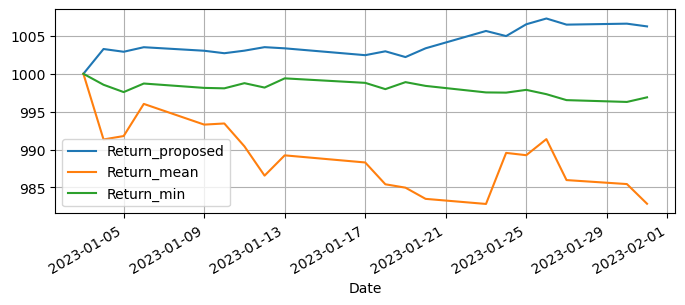

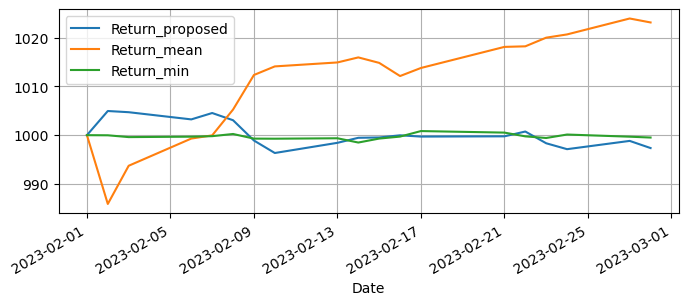

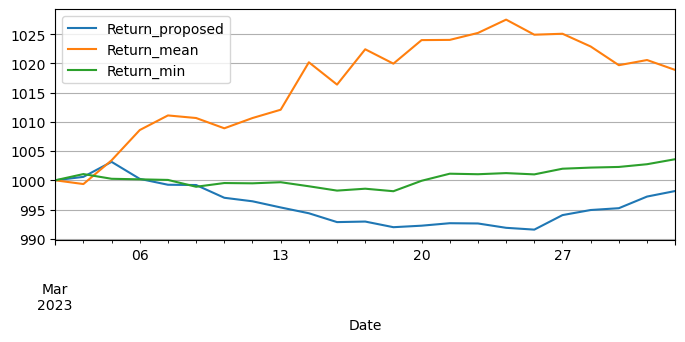

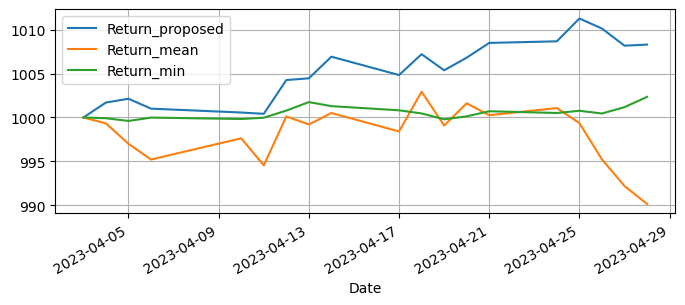

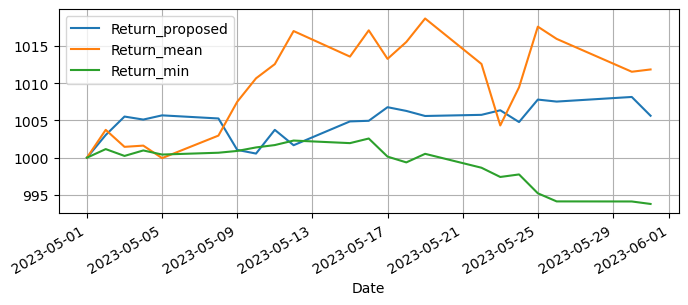

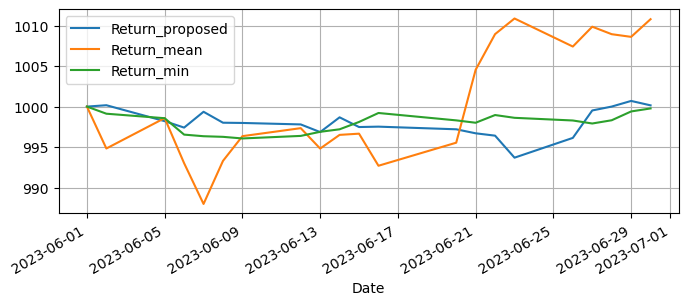

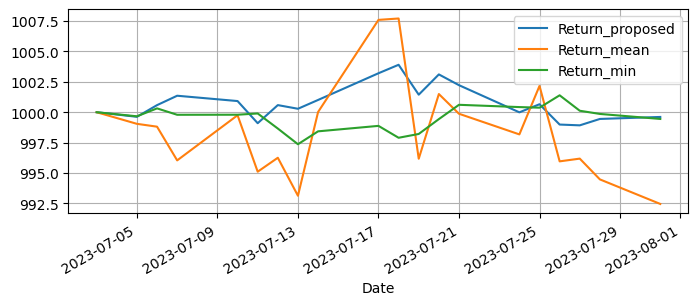

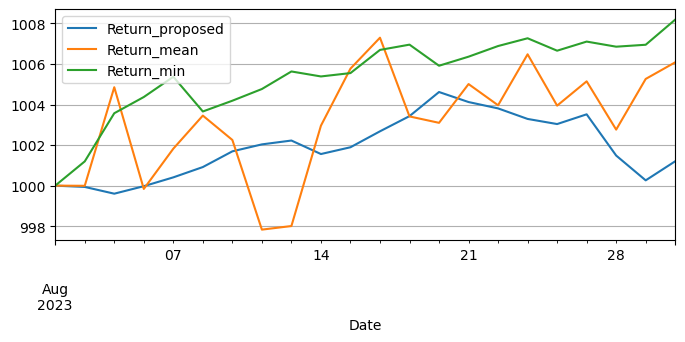

In [29]:
#Plot the results
for i in range (12):
    proposed_12_fold_read[i].plot(figsize=(8,3))
    mean_12_fold_read[i].plot(figsize=(8,3))
    min_12_fold_read[i].plot(figsize=(8,3))
    plt.grid()
    plt.legend()
    plt.show()

In [30]:
for i in range (12):
    print("fold " + str(i + 1))
    print("\n Proposed method \n")
    evaluation.Strategy_Evaluation(proposed_12_fold_read[i])
    print("\n Mean Variance method \n")
    evaluation.Strategy_Evaluation(mean_12_fold_read[i])
    print("\n Min Variance method \n")
    evaluation.Strategy_Evaluation(min_12_fold_read[i])
    print("\n")
    print("\n")

fold 1

 Proposed method 

Percentage Profit: 0.742%
Profit Factor: 1.773
Percentage Drawdown: 0.614%
Recovery Factor: 1.192
Sharpe Ratio: 3.513
Sortino Ratio: 4.294

 Mean Variance method 

Percentage Profit: 0.571%
Profit Factor: 1.328
Percentage Drawdown: 0.935%
Recovery Factor: 0.606
Sharpe Ratio: 1.785
Sortino Ratio: 2.442

 Min Variance method 

Percentage Profit: 0.335%
Profit Factor: 1.747
Percentage Drawdown: 0.249%
Recovery Factor: 1.343
Sharpe Ratio: 3.185
Sortino Ratio: 9.329




fold 2

 Proposed method 

Percentage Profit: 0.966%
Profit Factor: 2.177
Percentage Drawdown: 0.209%
Recovery Factor: 4.587
Sharpe Ratio: 5.147
Sortino Ratio: 10.085

 Mean Variance method 

Percentage Profit: -0.081%
Profit Factor: 0.977
Percentage Drawdown: 2.003%
Recovery Factor: -0.04
Sharpe Ratio: -0.129
Sortino Ratio: -0.141

 Min Variance method 

Percentage Profit: 0.648%
Profit Factor: 2.184
Percentage Drawdown: 0.42%
Recovery Factor: 1.53
Sharpe Ratio: 5.011
Sortino Ratio: 6.966




fold

Compare bench mark with earnings

In [33]:

 #Evaluate results
# all_proposed = []
# for reduce in range(1, 20):
#     reduce_earning = reduce / 10
#     port_test_12fold = list()

reduce_earning = 1.0
proposed = pd.read_csv(f'./results/earning_filter/benchmark_with_earning_filter_{reduce_earning}_100_port_test.txt', header = None, sep = '\t')
i = 0
skip_rows = list()
for item in proposed[0]:
    if proposed[0][i] == "Name: Portfolio, dtype: float64" or proposed[0][i] == "Date":
        skip_rows.append(i)
    i = i + 1
proposed_deleted = pd.read_csv('proposed_model_and_statistics.txt', header = None, sep = '    ', skiprows = skip_rows)
proposed_deleted[0] = pd.to_datetime(proposed_deleted[0])
proposed_deleted.columns =['Date', 'Return_proposed']
proposed_deleted = proposed_deleted.set_index('Date')
proposed_12_fold_read = list()
for i in range(12):
    month = i + 9
    if month > 12:
        month = month - 12
        
    temp = proposed_deleted.loc[
        proposed_deleted.index.month == month
    ]
    series = temp.iloc[:,0]
    temp = pd.Series(series, index = temp.index) 
    proposed_12_fold_read.append(temp)
# all_proposed.append(proposed_12_fold_read)

/var/folders/75/sbcy5_zx3yxgz1xj55ggdxd80000gn/T/ipykernel_10603/2524833319.py:15: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  proposed_deleted = pd.read_csv('proposed_model_and_statistics.txt', header = None, sep = '    ', skiprows = skip_rows)


In [25]:
print(all_proposed)

[[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []]


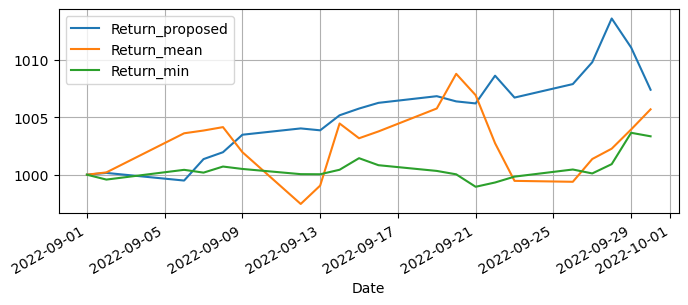

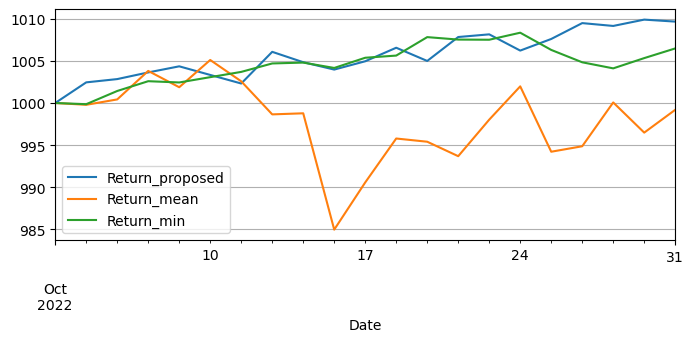

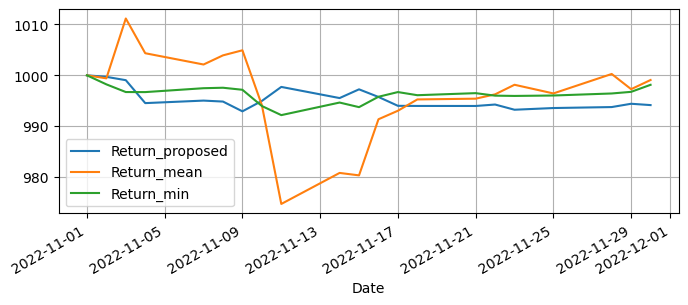

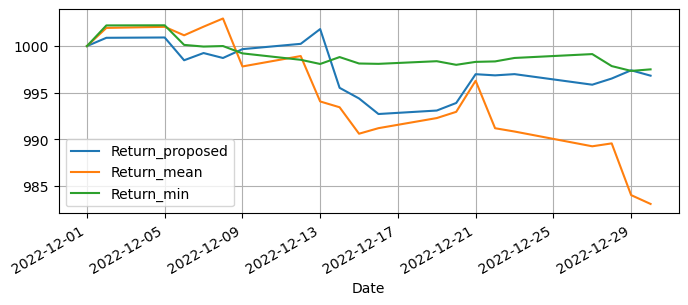

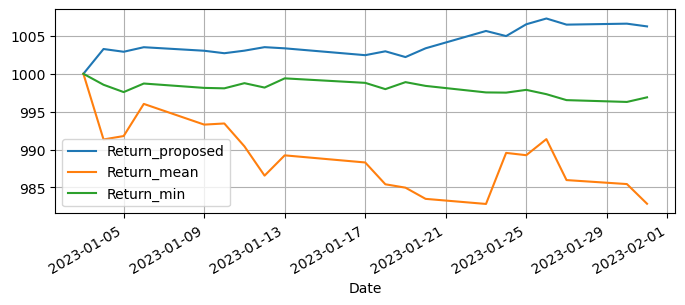

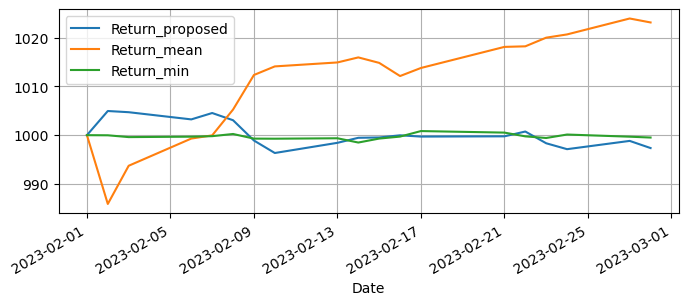

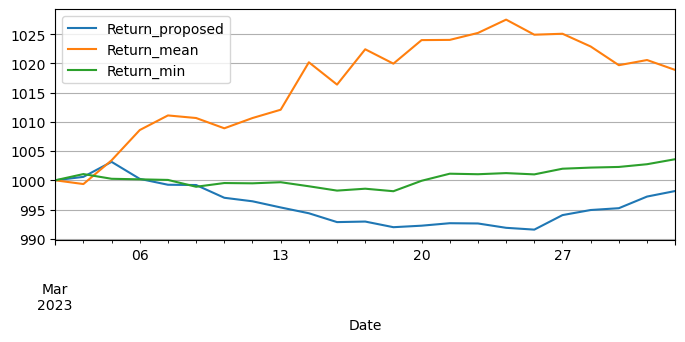

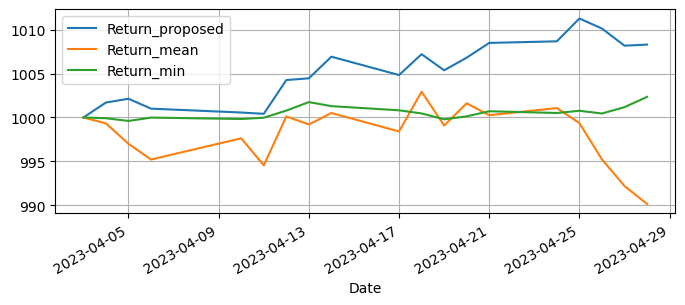

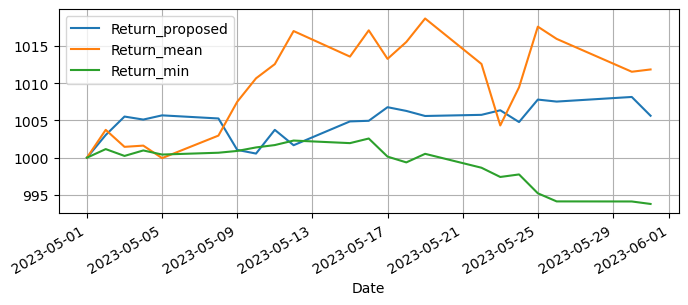

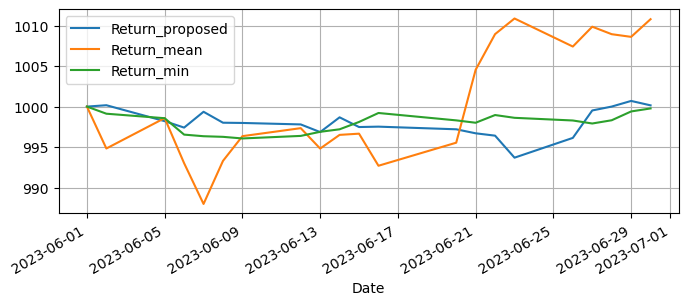

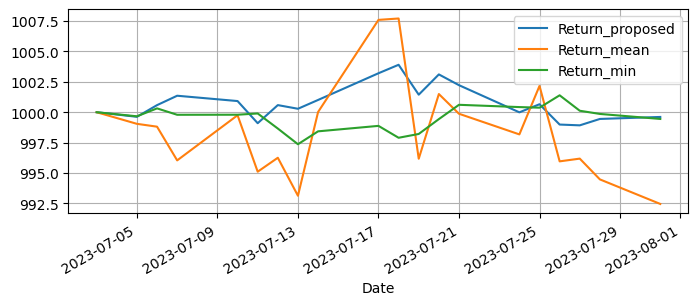

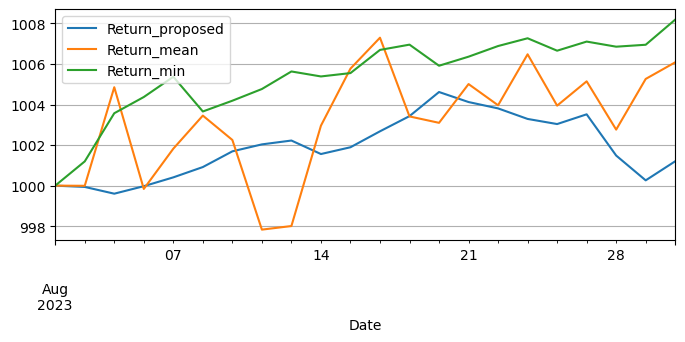

In [34]:
#Plot the results
for i in range (12):
    proposed_12_fold_read[i].plot(figsize=(8,3))
    mean_12_fold_read[i].plot(figsize=(8,3))
    min_12_fold_read[i].plot(figsize=(8,3))
    plt.grid()
    plt.legend()
    plt.show()